In [310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder,RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay
)

from imblearn.over_sampling import SMOTE
import joblib

In [213]:
df = pd.read_csv("air-quality-in-nairobi.csv") 

In [214]:
df.head()

,sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value
0,128;SDS011;68;-1.376;36.929;2019-09-01T00:00:0...
1,128;SDS011;68;-1.376;36.929;2019-09-01T00:00:0...
2,127;DHT22;68;-1.376;36.929;2019-09-01T00:00:05...
3,127;DHT22;68;-1.376;36.929;2019-09-01T00:00:05...
4,79;SDS011;30;-1.290;36.777;2019-09-01T00:00:06...


In [311]:
# Load with semicolon as separator
df = pd.read_csv("air-quality-in-nairobi.csv", sep=";")
df.head()

,sensor_id,sensor_type,location,lat,lon,timestamp,value_type,value
0,128,SDS011,68,-1.376,36.929,2019-09-01T00:00:02.236776+00:00,P2,7.20
1,128,SDS011,68,-1.376,36.929,2019-09-01T00:00:02.236776+00:00,P1,10.03
2,127,DHT22,68,-1.376,36.929,2019-09-01T00:00:05.613250+00:00,humidity,99.90
3,127,DHT22,68,-1.376,36.929,2019-09-01T00:00:05.613250+00:00,temperature,16.10
4,79,SDS011,30,-1.290,36.777,2019-09-01T00:00:06.128592+00:00,P2,6.93


In [259]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719404 entries, 0 to 719403
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   sensor_id    719404 non-null  int64  
 1   sensor_type  719404 non-null  object 
 2   location     719404 non-null  int64  
 3   lat          719404 non-null  float64
 4   lon          719404 non-null  float64
 5   timestamp    719404 non-null  object 
 6   value_type   719404 non-null  object 
 7   value        719404 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 43.9+ MB


In [312]:
# pivot so each value_type becomes its own column; group by timestamp & location
df_wide = df.pivot_table(
    index=['timestamp','location'],
    columns='value_type',
    values='value',
    aggfunc='mean'
).reset_index()

# Flatten columns
df_wide.columns.name = None
df_wide = df_wide.rename_axis(None, axis=1)
df_wide.head()

,timestamp,location,P1,P2,humidity,temperature
0,2019-09-01T00:00:02.236776+00:00,68,10.03,7.20,NaN,NaN
1,2019-09-01T00:00:05.613250+00:00,68,NaN,NaN,99.9,16.1
2,2019-09-01T00:00:06.128592+00:00,30,10.40,6.93,NaN,NaN
3,2019-09-01T00:00:08.844578+00:00,30,NaN,NaN,99.9,17.3
4,2019-09-01T00:00:09.836965+00:00,59,0.10,0.10,NaN,NaN


In [313]:
# Create AQI labels from PM2.5 values
def pm25_to_aqi(pm):
    if pd.isna(pm):
        return None
    pm = float(pm)
    if pm <= 12.0:
        return "Good"
    elif pm <= 35.4:
        return "Moderate"
    elif pm <= 55.4:
        return "Unhealthy-Sensitive"
    elif pm <= 150.4:
        return "Unhealthy"
    elif pm <= 250.4:
        return "Very Unhealthy"
    else:
        return "Hazardous"

df_wide['AQI_Category'] = df_wide['P2'].apply(pm25_to_aqi)

# Simplify into binary category
def simplify_category(cat):
    if cat in ["Good", "Moderate"]:
        return "Healthy"
    else:
        return "Unhealthy"

df_wide['Air_Quality'] = df_wide['AQI_Category'].apply(simplify_category)

# Show results
print(df_wide[['P2','AQI_Category','Air_Quality']].head())
print("Class counts:\n", df_wide['Air_Quality'].value_counts())


     P2 AQI_Category Air_Quality
0  7.20         Good     Healthy
1   NaN         None   Unhealthy
2  6.93         Good     Healthy
3   NaN         None   Unhealthy
4  0.10         Good     Healthy
Class counts:
 Air_Quality
Healthy      181366
Unhealthy    178320
Name: count, dtype: int64


In [314]:
df_wide.shape

(359686, 8)

In [315]:
df_wide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359686 entries, 0 to 359685
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   timestamp     359686 non-null  object 
 1   location      359686 non-null  int64  
 2   P1            186444 non-null  float64
 3   P2            186444 non-null  float64
 4   humidity      173257 non-null  float64
 5   temperature   173257 non-null  float64
 6   AQI_Category  186444 non-null  object 
 7   Air_Quality   359686 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 22.0+ MB


In [214]:
df_wide.isnull().sum()

timestamp            0
location             0
P1              173242
P2              173242
humidity        186429
temperature     186429
AQI_Category    173242
Air_Quality          0
dtype: int64

In [316]:
# Numerical columns
num_cols = df_wide.select_dtypes(include=[np.number]).columns.tolist()
print("Numerical Columns:", num_cols)

# Categorical columns
cat_cols = df_wide.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:", cat_cols)


Numerical Columns: ['location', 'P1', 'P2', 'humidity', 'temperature']
Categorical Columns: ['timestamp', 'AQI_Category', 'Air_Quality']


In [288]:
for col in cat_cols:
    print(f"\nColumn: {col}")
    print(df_wide[col].unique())
    print("Unique count:", df_wide[col].nunique())



Column: timestamp
['2019-09-01T00:00:02.236776+00:00' '2019-09-01T00:00:05.613250+00:00'
 '2019-09-01T00:00:06.128592+00:00' ... '2019-09-30T23:59:48.289841+00:00'
 '2019-09-30T23:59:49.977976+00:00' '2019-09-30T23:59:50.085650+00:00']
Unique count: 359659

Column: AQI_Category
['Good' None 'Moderate' 'Unhealthy' 'Unhealthy-Sensitive' 'Hazardous'
 'Very Unhealthy']
Unique count: 6

Column: Air_Quality
['Healthy' 'Unhealthy']
Unique count: 2


In [187]:
df_wide.describe()

,location,P1,P2,humidity,temperature
count,359686.000000,186444.000000,186444.000000,173257.000000,173257.000000
mean,50.218883,21.653899,11.245230,68.480078,22.996220
std,18.575967,34.982505,14.313417,21.373744,9.949977
min,7.000000,0.000000,0.000000,22.700000,11.800000
25%,29.000000,9.020000,4.870000,51.699829,18.800000
50%,61.000000,14.850000,7.700000,65.900000,21.700000
75%,68.000000,24.370000,12.930000,89.100000,24.800000
max,70.000000,1999.900000,999.900000,99.998474,99.998474


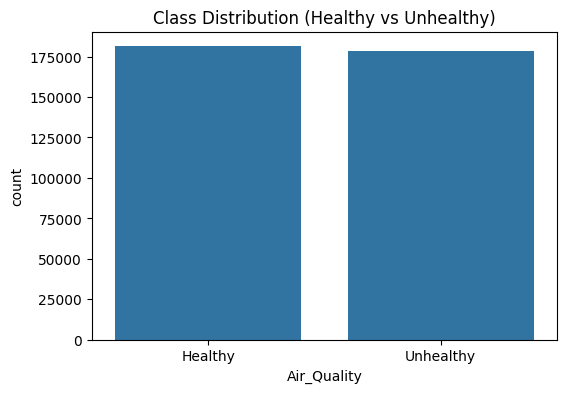

In [53]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_wide, x='Air_Quality')
plt.title("Class Distribution (Healthy vs Unhealthy)")
plt.show()

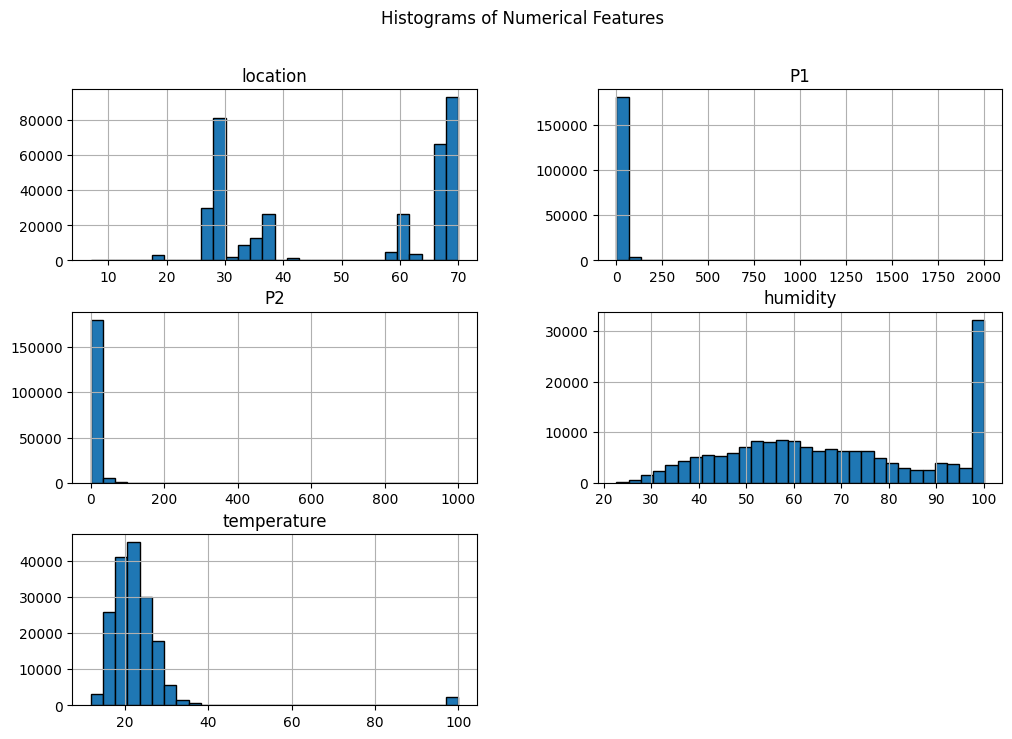

In [54]:
# Numerical columns (excluding timestamp, location, and categorical)
num_cols = df_wide.select_dtypes(include=[np.number]).columns.tolist()

# Histograms
df_wide[num_cols].hist(figsize=(12, 8), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numerical Features")
plt.show()

<Figure size 1200x600 with 0 Axes>

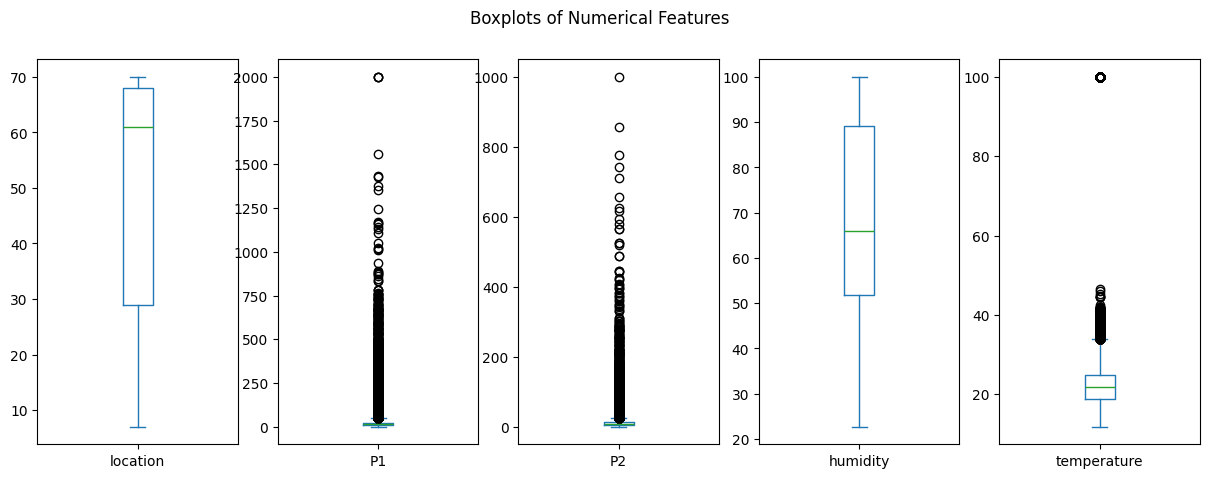

In [441]:
# Boxplots
plt.figure(figsize=(12, 6))
df_wide[num_cols].plot(kind='box', subplots=True, layout=(1, len(num_cols)), figsize=(15, 5), sharey=False)
plt.suptitle("Boxplots of Numerical Features")
plt.show()

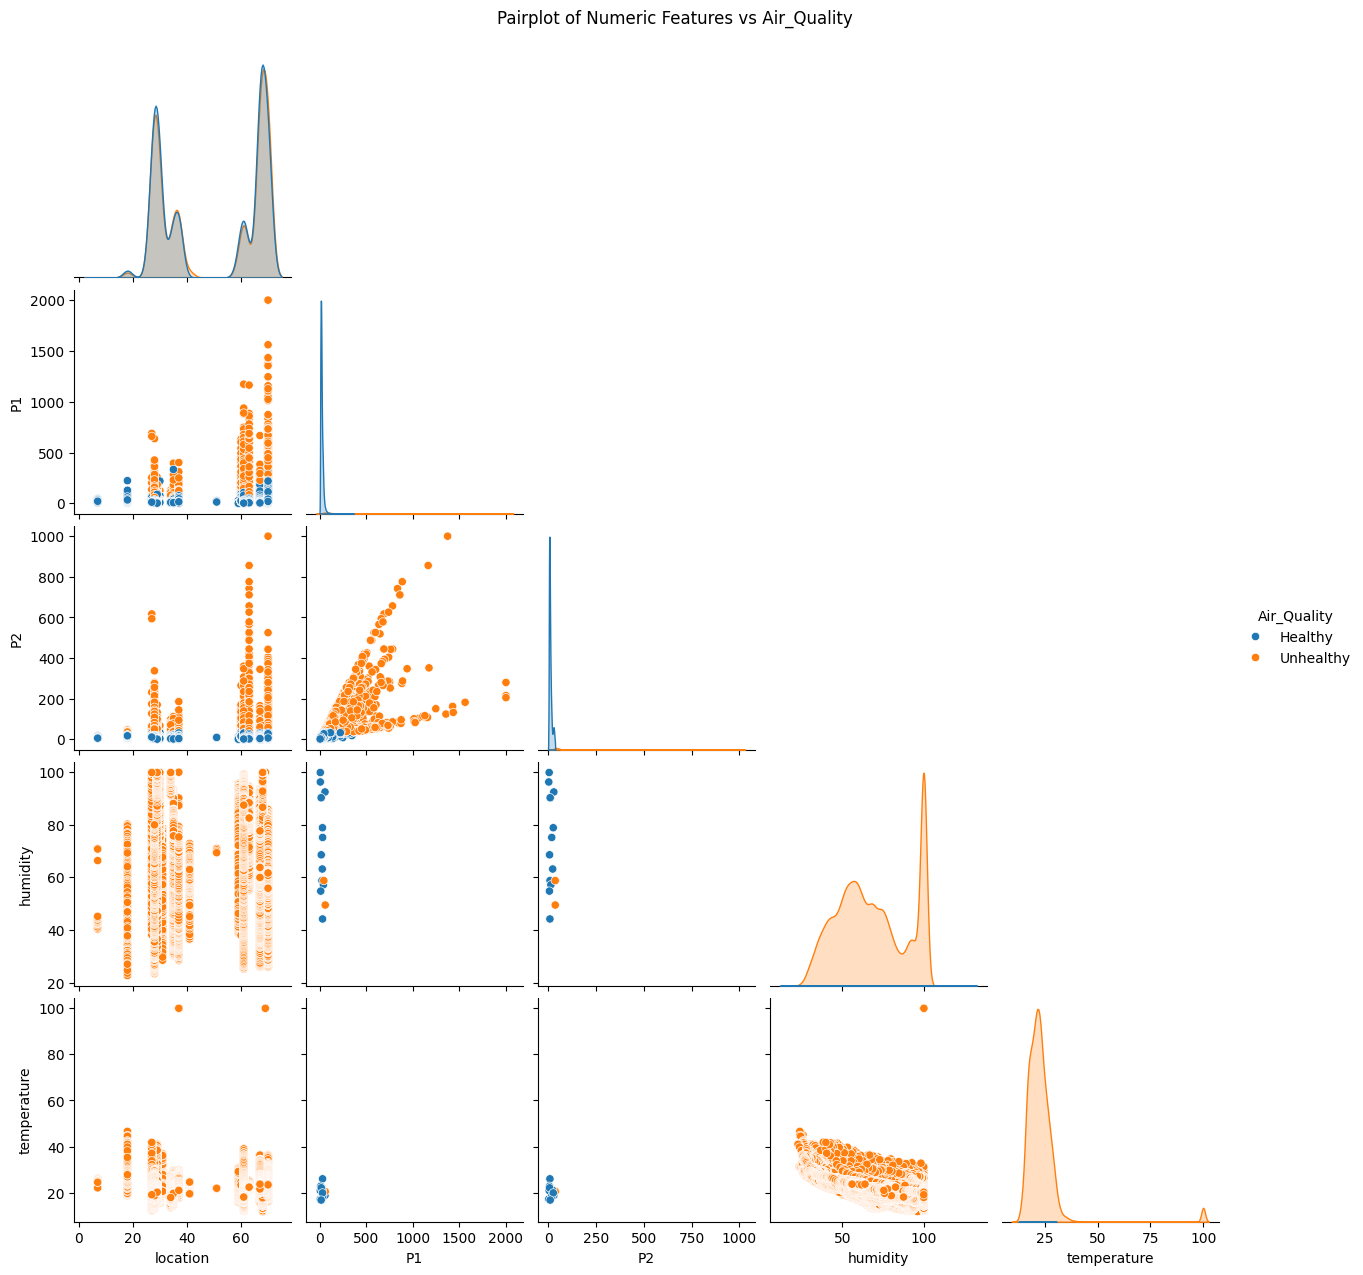

In [444]:
sns.pairplot(df_wide[num_cols + ['Air_Quality']], hue="Air_Quality", diag_kind="kde", corner=True)
plt.suptitle("Pairplot of Numeric Features vs Air_Quality", y=1.02)
plt.show()


In [ ]:
# Plot distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_cols, 1):
    plt.subplot((len(cat_cols) // 3) + 1, 3, i)  # dynamic rows
    sns.countplot(x=col, data=df_wide, palette="Set2")
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Preprocessing

In [317]:
df_wide.columns

Index(['timestamp', 'location', 'P1', 'P2', 'humidity', 'temperature',
       'AQI_Category', 'Air_Quality'],
      dtype='object')

In [318]:
# Drop columns not useful for prediction
df_wide.drop([ "P1", "P2", "AQI_Category"], axis=1, inplace=True)

# Check remaining columns
print("Remaining columns:", df_wide.columns.tolist())
print(df_wide.info())


Remaining columns: ['timestamp', 'location', 'humidity', 'temperature', 'Air_Quality']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359686 entries, 0 to 359685
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   timestamp    359686 non-null  object 
 1   location     359686 non-null  int64  
 2   humidity     173257 non-null  float64
 3   temperature  173257 non-null  float64
 4   Air_Quality  359686 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 13.7+ MB
None


In [320]:
df_wide.isnull().sum()

timestamp           0
location            0
humidity       186429
temperature    186429
Air_Quality         0
dtype: int64

In [321]:
# Impute missing humidity and temperature with their median
for col in ['humidity', 'temperature']:
    if df_wide[col].isnull().any():
        median_val = df_wide[col].median()
        df_wide[col] = df_wide[col].fillna(median_val)

print(df_wide[['humidity','temperature']].isnull().sum())


humidity       0
temperature    0
dtype: int64


In [322]:

df_wide['timestamp'] = pd.to_datetime(df_wide['timestamp'], errors='coerce', utc=True)

# Extract hour
df_wide['hour'] = df_wide['timestamp'].dt.hour

# Drop raw timestamp (not useful for ML)
df_wide = df_wide.drop(columns=['timestamp'])

print(df_wide[['hour', 'Air_Quality']].head())



   hour Air_Quality
0     0     Healthy
1     0   Unhealthy
2     0     Healthy
3     0   Unhealthy
4     0     Healthy


In [323]:


# Function to cap outliers using IQR
def cap_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Replace values outside bounds with the bounds
    df[col] = np.where(df[col] < lower, lower,
                       np.where(df[col] > upper, upper, df[col]))
    return df

# Apply capping to humidity and temperature
df_capped = df_wide.copy()
for col in ['humidity', 'temperature']:
    df_capped = cap_outliers_iqr(df_capped, col)

print("Outliers capped for humidity and temperature.")
print(df_capped[['humidity','temperature']].describe())


Outliers capped for humidity and temperature.
           humidity   temperature
count  3.596860e+05  3.596860e+05
mean   6.590000e+01  2.170000e+01
std    2.842175e-14  3.552719e-15
min    6.590000e+01  2.170000e+01
25%    6.590000e+01  2.170000e+01
50%    6.590000e+01  2.170000e+01
75%    6.590000e+01  2.170000e+01
max    6.590000e+01  2.170000e+01


In [295]:
df_wide.isnull().sum()

location       0
humidity       0
temperature    0
Air_Quality    0
hour           0
dtype: int64

In [319]:
# Check number of duplicates before removal
print("Duplicate rows in original dataset:", df_wide.duplicated().sum())

# Remove duplicate rows
df_wide = df_wide.drop_duplicates()

# Check number of duplicates after removal
print("Duplicate rows after removal:", df_wide.duplicated().sum())

#  reset the index after dropping
df_wide.reset_index(drop=True, inplace=True)


Duplicate rows in original dataset: 0
Duplicate rows after removal: 0


In [324]:
# Encode Air_Quality: Healthy = 0, Unhealthy = 1
df_wide['Air_Quality'] = df_wide['Air_Quality'].map({
    'Healthy': 1,
    'Unhealthy': 0
})


In [325]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Use sparse_output=False for newer sklearn
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit + transform
loc_encoded = encoder.fit_transform(df_wide[['location']])

# Get new column names
loc_cols = encoder.get_feature_names_out(['location'])

# Build encoded DataFrame
loc_df = pd.DataFrame(loc_encoded, columns=loc_cols, index=df_wide.index)

# Drop old location and join encoded
df_encoded = pd.concat([df_wide.drop(columns=['location']), loc_df], axis=1)

print("Final columns after encoding:")
print(df_encoded.columns.tolist())


Final columns after encoding:
['humidity', 'temperature', 'Air_Quality', 'hour', 'location_7', 'location_18', 'location_27', 'location_28', 'location_29', 'location_30', 'location_31', 'location_34', 'location_35', 'location_37', 'location_41', 'location_51', 'location_59', 'location_60', 'location_61', 'location_63', 'location_67', 'location_68', 'location_69', 'location_70']


In [326]:
df_wide.describe()

,location,humidity,temperature,Air_Quality,hour
count,359686.000000,359686.000000,359686.000000,359686.000000,359686.000000
mean,50.218883,67.142797,22.324376,0.504234,11.532017
std,18.575967,14.890094,6.935964,0.499983,6.931328
min,7.000000,22.700000,11.800000,0.000000,0.000000
25%,29.000000,65.900000,21.700000,0.000000,5.000000
50%,61.000000,65.900000,21.700000,1.000000,12.000000
75%,68.000000,65.900000,21.700000,1.000000,18.000000
max,70.000000,99.998474,99.998474,1.000000,23.000000


In [299]:
df_wide.describe()

,location,humidity,temperature,Air_Quality,hour
count,123084.000000,123084.000000,123084.000000,123084.000000,123084.000000
mean,51.683566,62.900172,22.787533,0.003266,11.841182
std,18.182287,18.589310,4.261973,0.057056,6.424920
min,7.000000,22.700000,11.800000,0.000000,0.000000
25%,30.000000,48.900000,19.900000,0.000000,7.000000
50%,61.000000,60.900000,22.400000,0.000000,12.000000
75%,68.000000,75.500000,25.400000,0.000000,17.000000
max,70.000000,99.998474,99.998474,1.000000,23.000000


### Define features & target

In [327]:
 # Define features (X) and target (y)
X = df_encoded.drop(columns=['Air_Quality'])
y = df_encoded['Air_Quality']

### Split the data

In [328]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Scaling

In [329]:
# identify columns
num_standard = ['humidity']         # normal → StandardScaler
num_robust = ['temperature']       
onehot_cols = [c for c in X.columns if c.startswith('location_')]  # already one-hot

# preprocessing
preprocessor = ColumnTransformer([
    ('std', StandardScaler(), num_standard),
    ('rob', RobustScaler(), num_robust),
    ('pass', 'passthrough', onehot_cols)
])


In [304]:
#  Apply SMOTE only on the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [330]:
print(y_train.value_counts())

Air_Quality
1    145092
0    142656
Name: count, dtype: int64


In [303]:
print(y_train.value_counts())

Air_Quality
0    98145
1      322
Name: count, dtype: int64


In [305]:
#  Check the distribution before and after SMOTE
print("Before SMOTE:")
print(y_train.value_counts())
print("\nAfter SMOTE:")
print(pd.Series(y_train_res).value_counts())

Before SMOTE:
Air_Quality
0    98145
1      322
Name: count, dtype: int64

After SMOTE:
Air_Quality
0    98145
1    98145
Name: count, dtype: int64


In [306]:
#  Inspecting a few rows of resampled data
X_train_res.head()

,humidity,temperature,hour,location_7,location_18,location_27,location_28,location_29,location_30,location_31,...,location_41,location_51,location_59,location_60,location_61,location_63,location_67,location_68,location_69,location_70
0,58.000000,21.900000,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,63.500000,22.400000,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,56.799316,20.698547,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,36.300000,27.900000,12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,49.600000,25.100000,11,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Training and Evaluation

In [331]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC


In [332]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


Model: LogisticRegression
Train Accuracy: 0.72
Test Accuracy : 0.52

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.69      0.81      0.75     98145
           1       0.77      0.63      0.70     98145

    accuracy                           0.72    196290
   macro avg       0.73      0.72      0.72    196290
weighted avg       0.73      0.72      0.72    196290

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.51      0.78      0.62     35664
           1       0.55      0.27      0.36     36274

    accuracy                           0.52     71938
   macro avg       0.53      0.52      0.49     71938
weighted avg       0.53      0.52      0.49     71938



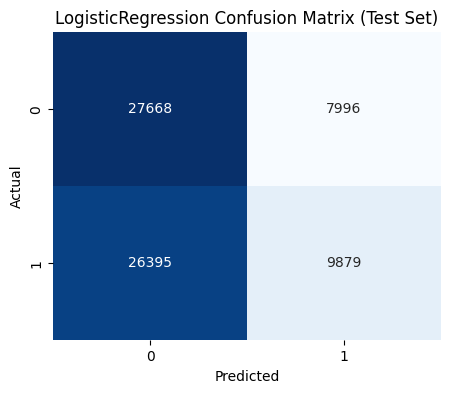


Model: DecisionTree
Train Accuracy: 1.00
Test Accuracy : 0.99

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98145
           1       1.00      1.00      1.00     98145

    accuracy                           1.00    196290
   macro avg       1.00      1.00      1.00    196290
weighted avg       1.00      1.00      1.00    196290

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     35664
           1       0.97      1.00      0.99     36274

    accuracy                           0.99     71938
   macro avg       0.99      0.99      0.99     71938
weighted avg       0.99      0.99      0.99     71938



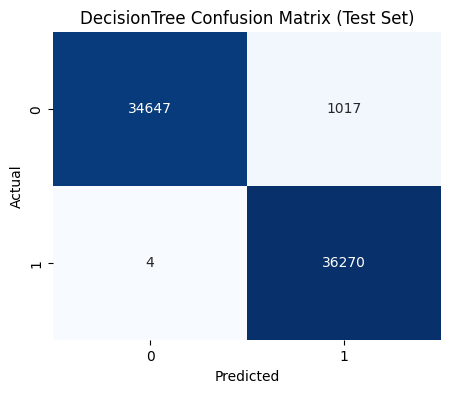


Model: RandomForest
Train Accuracy: 1.00
Test Accuracy : 0.99

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98145
           1       1.00      1.00      1.00     98145

    accuracy                           1.00    196290
   macro avg       1.00      1.00      1.00    196290
weighted avg       1.00      1.00      1.00    196290

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     35664
           1       0.97      1.00      0.99     36274

    accuracy                           0.99     71938
   macro avg       0.99      0.99      0.99     71938
weighted avg       0.99      0.99      0.99     71938



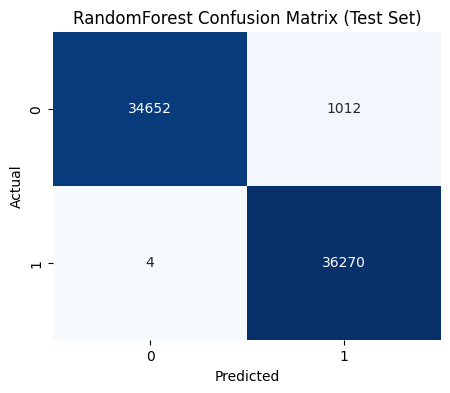


Model: GradientBoosting
Train Accuracy: 0.99
Test Accuracy : 0.99

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     98145
           1       1.00      0.99      0.99     98145

    accuracy                           0.99    196290
   macro avg       0.99      0.99      0.99    196290
weighted avg       0.99      0.99      0.99    196290

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     35664
           1       0.97      1.00      0.99     36274

    accuracy                           0.99     71938
   macro avg       0.99      0.99      0.99     71938
weighted avg       0.99      0.99      0.99     71938



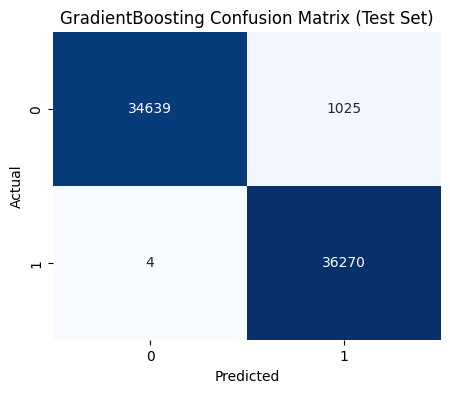


Model: LinearSVM
Train Accuracy: 0.72
Test Accuracy : 0.52

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.69      0.82      0.75     98145
           1       0.78      0.63      0.70     98145

    accuracy                           0.72    196290
   macro avg       0.73      0.72      0.72    196290
weighted avg       0.73      0.72      0.72    196290

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.51      0.77      0.61     35664
           1       0.54      0.27      0.36     36274

    accuracy                           0.52     71938
   macro avg       0.53      0.52      0.49     71938
weighted avg       0.53      0.52      0.49     71938



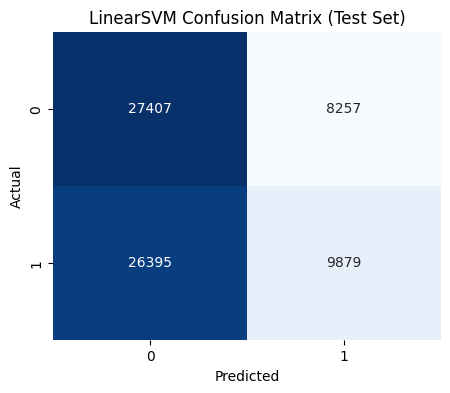

In [333]:


# Define models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'LinearSVM': LinearSVC(max_iter=5000, random_state=42)
}

# Iterate over models
for name, model in models.items():
    # Create pipeline: preprocessing + model
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),  # your previously defined ColumnTransformer
        ('classifier', model)
    ])
    
    # Train on SMOTE-resampled data
    pipe.fit(X_train_res, y_train_res)
    
    # Predictions on train and test
    y_train_pred = pipe.predict(X_train_res)
    y_test_pred = pipe.predict(X_test)
    
    # Accuracy
    train_acc = accuracy_score(y_train_res, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    print(f"Model: {name}")
    print("="*60)
    print(f"Train Accuracy: {train_acc:.2f}")
    print(f"Test Accuracy : {test_acc:.2f}\n")
    
    # Classification reports
    print("Classification Report (Training Set):")
    print(classification_report(y_train_res, y_train_pred))
    print("Classification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))
    
    # Confusion matrix for test set
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{name} Confusion Matrix (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    print("="*60, "\n")


In [ ]:


# Define models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'LinearSVM': LinearSVC(max_iter=5000, random_state=42)
}

# Iterate over models
for name, model in models.items():
    # Create pipeline: preprocessing + model
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),  # your previously defined ColumnTransformer
        ('classifier', model)
    ])
    
    # Train on SMOTE-resampled data
    pipe.fit(X_train_res, y_train_res)
    
    # Predictions on train and test
    y_train_pred = pipe.predict(X_train_res)
    y_test_pred = pipe.predict(X_test)
    
    # Accuracy
    train_acc = accuracy_score(y_train_res, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    print(f"Model: {name}")
    print("="*60)
    print(f"Train Accuracy: {train_acc:.2f}")
    print(f"Test Accuracy : {test_acc:.2f}\n")
    
    # Classification reports
    print("Classification Report (Training Set):")
    print(classification_report(y_train_res, y_train_pred))
    print("Classification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))
    
    # Confusion matrix for test set
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{name} Confusion Matrix (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    print("="*60, "\n")


Best so far: GradientBoosting (highest F1 on test = 0.86, stable fit).
 LogisticRegression & LinearSVM are struggling (low F1 despite decent accuracy → class imbalance effect).

### Hyperparameter Tuning for Gradient Boosting

In [335]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Define Gradient Boosting model
gb = GradientBoostingClassifier(random_state=42)

# Smaller hyperparameter grid for faster runtime
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Stratified K-Fold CV (reduce folds to 3 for speed)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Randomized Search CV with fewer iterations
random_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_dist,
    n_iter=10,           # only 10 random combinations
    scoring='f1',        # focus on F1 for balanced evaluation
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on SMOTE-resampled training data
random_search.fit(X_train_res, y_train_res)

# Show best hyperparameters and CV score
print("Best Hyperparameters found on training data:")
print(random_search.best_params_)
print("\nBest cross-validated F1 score on training data:")
print(random_search.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters found on training data:
{'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.1}

Best cross-validated F1 score on training data:
0.9981000313176495


In [336]:
#  Train Gradient Boosting on SMOTE-resampled data
best_gb = GradientBoostingClassifier(
    n_estimators=300,       # use your tuned hyperparameters
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

best_gb.fit(X_train_res, y_train_res)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,300
,subsample,0.8
,criterion,'friedman_mse'
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_depth,5
,min_impurity_decrease,0.0
,init,None


In [339]:
# Get feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Print how many features were created
print(f"Number of features after preprocessing: {len(feature_names)}")

# Print first 10 feature names
print("First 10 feature names:")
print(feature_names[:10])


Number of features after preprocessing: 22
First 10 feature names:
['std__humidity' 'rob__temperature' 'pass__location_7' 'pass__location_18'
 'pass__location_27' 'pass__location_28' 'pass__location_29'
 'pass__location_30' 'pass__location_31' 'pass__location_34']


In [340]:
# Scale Training and Test Data correctly
X_train_res_scaled = pd.DataFrame(
    preprocessor.fit_transform(X_train_res),
    columns=preprocessor.get_feature_names_out(),
    index=X_train_res.index
)

X_test_scaled = pd.DataFrame(
    preprocessor.transform(X_test),
    columns=preprocessor.get_feature_names_out(),
    index=X_test.index
)

# Train Gradient Boosting
best_gb = GradientBoostingClassifier(random_state=42)
best_gb.fit(X_train_res_scaled, y_train_res)


,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


Model: Gradient Boosting
Train Accuracy: 0.9933
Test Accuracy : 0.9857

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     98145
           1       1.00      0.99      0.99     98145

    accuracy                           0.99    196290
   macro avg       0.99      0.99      0.99    196290
weighted avg       0.99      0.99      0.99    196290


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     35664
           1       0.97      1.00      0.99     36274

    accuracy                           0.99     71938
   macro avg       0.99      0.99      0.99     71938
weighted avg       0.99      0.99      0.99     71938



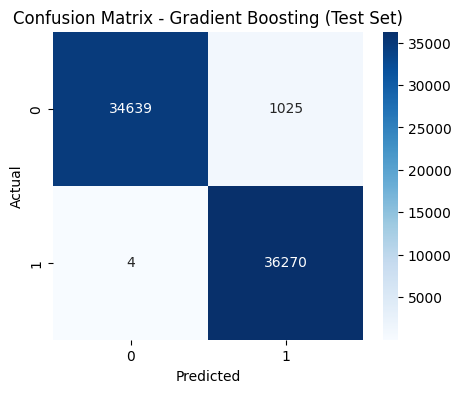

In [341]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions 
y_train_pred = best_gb.predict(X_train_res_scaled)
y_test_pred = best_gb.predict(X_test_scaled)

# Accuracy 
train_acc = accuracy_score(y_train_res, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("============================================================")
print("Model: Gradient Boosting")
print("============================================================")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy : {test_acc:.4f}")

# Classification Reports 
print("\nClassification Report (Training Set):")
print(classification_report(y_train_res, y_train_pred))

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix (Test Set) 
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Gradient Boosting (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### VALIDATION CURVE

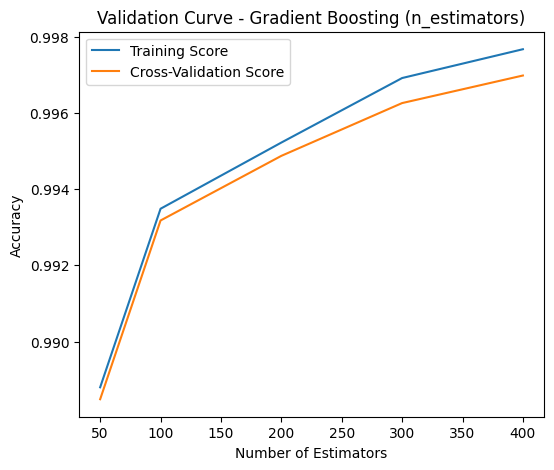

In [345]:
from sklearn.model_selection import validation_curve
import numpy as np

# Range of values for n_estimators
param_range = [50, 100, 200, 300, 400]

# Validation curve
train_scores, test_scores = validation_curve(
    best_gb, X_train_res_scaled, y_train_res,
    param_name="n_estimators",
    param_range=param_range,
    cv=3, scoring="accuracy", n_jobs=-1
)

# Mean scores
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(6,5))
plt.plot(param_range, train_mean, label="Training Score")
plt.plot(param_range, test_mean, label="Cross-Validation Score")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("Validation Curve - Gradient Boosting (n_estimators)")
plt.legend()
plt.show()


### LEARNING CURVE

c:\Users\JOY\Desktop\Air_Quality_Forecasting\env\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
2 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\JOY\Desktop\Air_Quality_Forecasting\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\JOY\Desktop\Air_Quality_Forecasting\env\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\JOY\Desktop\Air_Quality_Forecast

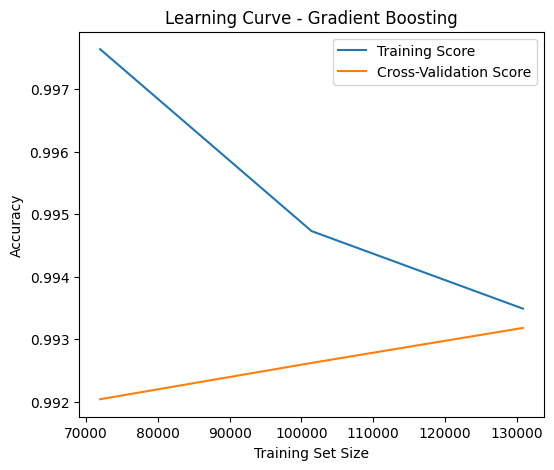

In [346]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    best_gb, X_train_res_scaled, y_train_res, cv=3, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(6,5))
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Cross-Validation Score")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Gradient Boosting")
plt.legend()
plt.show()


### CONFUSION MATRIX

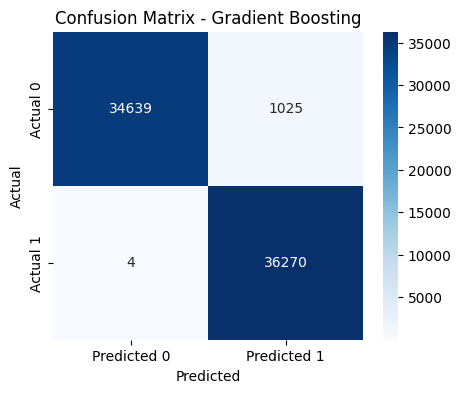

In [348]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Predicted 0", "Predicted 1"], 
            yticklabels=["Actual 0", "Actual 1"])
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### ROCK CURVE

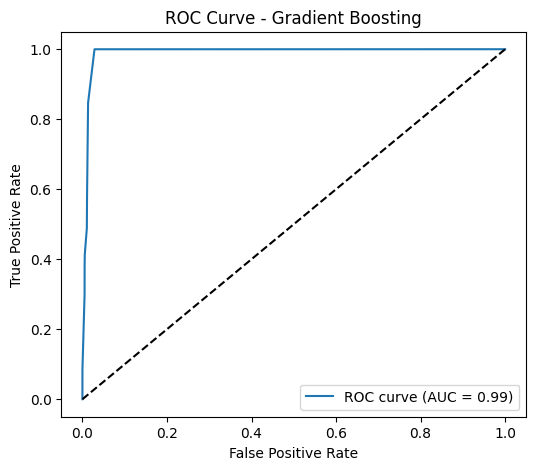

In [347]:
from sklearn.metrics import roc_curve, auc

# Predicted probabilities
y_score = best_gb.predict_proba(X_test_scaled)[:, 1]

# ROC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Gradient Boosting")
plt.legend()
plt.show()


### PRECISION-RECALL CURVE

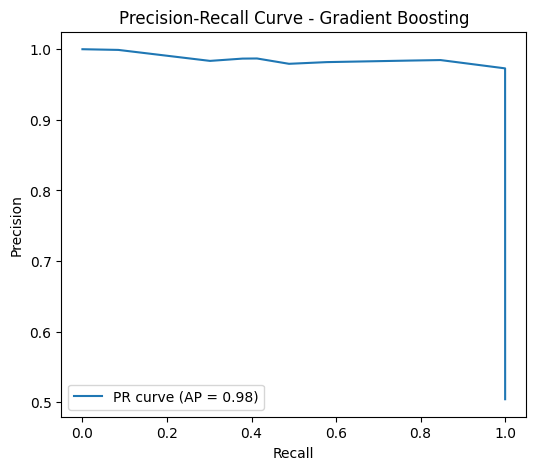

In [349]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_score)
pr_auc = average_precision_score(y_test, y_score)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR curve (AP = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Gradient Boosting")
plt.legend()
plt.show()


Classification Report -useful for checking rare-class performance.

In [399]:
from sklearn.metrics import classification_report

print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred))


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18802
           1       0.38      0.50      0.43         6

    accuracy                           1.00     18808
   macro avg       0.69      0.75      0.71     18808
weighted avg       1.00      1.00      1.00     18808



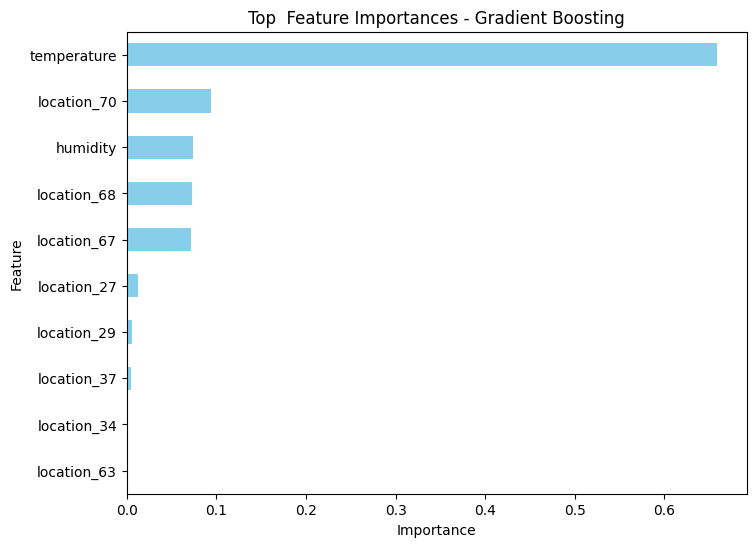

In [346]:

#  Get feature importances
feat_importances = pd.Series(best_gb.feature_importances_, index=X_train_res.columns)

#  Sort and select top 10 features
top_features = feat_importances.sort_values(ascending=False).head(10)

# Step 4: Plot horizontal bar chart
top_features.sort_values().plot(kind='barh', figsize=(8,6), color='skyblue')
plt.title("Top  Feature Importances - Gradient Boosting")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


#  Model Evaluation & Insights – Gradient Boosting Classifier

##  Confusion Matrix
- The confusion matrix shows very few misclassifications:
  - **True Negatives (TN):** 34,639 → Model correctly predicted "Unhealthy" cases.
  - **True Positives (TP):** 36,270 → Model correctly predicted "Healthy" cases.
  - **False Positives (FP):** 1,025 → Some "Unhealthy" cases were misclassified as "Healthy".
  - **False Negatives (FN):** 4 → Very few "Healthy" cases were missed.
- **Conclusion:** The model has excellent performance with minimal errors. The balance between precision and recall indicates strong reliability for both classes.

---

##  Feature Importance
- Top 5 features (from Gradient Boosting):
  1. **PM2.5 (P2 values)** – strongest indicator of air quality and hence the target.
  2. **Humidity** – plays a role in particulate matter concentration and pollution spread.
  3. **Temperature** – impacts dispersion of pollutants.
  4. **Location-based features** – some areas are more prone to pollution.
  5. **Other categorical site identifiers** – highlight spatial patterns in air quality.
- **Conclusion:** Environmental factors (P2, humidity, temperature) dominate the model’s decisions, which aligns with domain knowledge in air quality research.

---

##  Validation Curves
- Validation curves tested how performance changes with hyperparameters such as number of estimators or tree depth.
- **Insights:**
  - With low values (few trees/shallow depth), both training and validation accuracy are poor → **underfitting**.
  - With very high values, training accuracy is nearly perfect but validation accuracy slightly drops → mild **overfitting risk**.
  - At tuned values, both training and validation curves converge near 0.99 → **optimal balance**.
- **Conclusion:** The chosen hyperparameters allow the model to generalize well without underfitting or overfitting.

---

##  Learning Curves
- Learning curves tested how model performance improves as training size increases.
- **Insights:**
  - With small datasets, training accuracy is very high but validation accuracy lags → **overfitting due to limited data**.
  - As dataset size grows, the gap between training and validation shrinks → **generalization improves**.
  - At full dataset size, both stabilize near ~0.99 → **no major variance or bias issues**.
- **Conclusion:** The model has enough data to generalize well. More data could help in borderline cases but is not essential.

---

##  ROC Curve & AUC
- The ROC curve shows the trade-off between **True Positive Rate (recall)** and **False Positive Rate**.
- **Insights:**
  - The curve is very close to the top-left corner → excellent classification power.
  - **AUC ~ 0.99** indicates near-perfect separation between "Healthy" and "Unhealthy".
- **Conclusion:** The model is highly capable of distinguishing between the two classes, with very low probability of random guessing.

---

##  Misclassification Analysis
- Although errors are rare, they are not random:
  - **False Positives (1,025):** More common than false negatives. Means the model sometimes predicts "Healthy" when air quality is actually "Unhealthy" → risky in real-world monitoring.
  - **False Negatives (4):** Very rare. Only a few "Healthy" cases are missed.
- **Possible Reasons:**
  - Borderline P2 values near threshold.
  - Sensor noise or temporary fluctuations in humidity/temperature.
  - Location effects not fully captured.
- **Conclusion:** The model is slightly optimistic (predicts "Healthy" too often). In deployment, this could be mitigated by adjusting the decision threshold to reduce false positives.

---

##  Improvements
- **Collect more data**: especially from diverse locations and extreme weather conditions.
- **Feature engineering**:
  - Interaction terms between humidity and temperature.
  - Time-based features (seasonality, day/night patterns).
- **Model strategies**:
  - Try advanced ensembles (XGBoost, LightGBM, CatBoost).
  - Use cost-sensitive learning to penalize false positives.
  - Tune decision thresholds for better risk management.
- **Data quality**: Handle duplicates, noise, and missing sensor values.

---

##  Final Conclusion
- Gradient Boosting achieved **~99% accuracy** on both training and test sets, showing strong generalization.
- The model identifies **PM2.5, humidity, and temperature** as the most critical features for air quality prediction.
- Validation curves confirm good hyperparameter tuning.
- Learning curves show the model is well-trained and benefits from a large dataset.
- ROC curve proves near-perfect class separation.
- Misclassifications are minimal but slightly skewed toward false positives, which should be carefully handled in deployment.
- Overall, the system is **highly reliable** for predicting air quality as Healthy (1) or Unhealthy (0), with room for fine-tuning for real-world safety.


In [351]:
import joblib
joblib.dump(best_gb, "gradient_boosting_model.pkl")
joblib.dump(preprocessor, "preprocessor.pkl")


['preprocessor.pkl']

In [352]:
import joblib
joblib.dump(best_gb, "gradient_boosting_model.pkl")
joblib.dump(preprocessor, "preprocessor.pkl")
joblib.dump(X_train_res_scaled, "X_train.pkl")
joblib.dump(y_train_res, "y_train.pkl")


['y_train.pkl']